In [237]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import sklearn as sk
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import string
import seaborn as sns
import pymorphy2
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import ExtraTreesClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import FeatureHasher
from sklearn.decomposition import PCA
import xgboost as xgb
%matplotlib inline
import pyphen
import re
import pyphen
# Create your first MLP in Keras
from keras.models import Sequential
from keras.layers import Dense
import re
from sklearn.cross_validation import cross_val_predict
from gensim.models import word2vec
from natasha import NamesExtractor

In [238]:
test = pd.read_csv('../test.csv' ) #, nrows=100
train = pd.read_csv('../train.csv') #, nrows=10000 

In [239]:
extractor = NamesExtractor()
pyphen.language_fallback('ru-t-en-latn-gb-h0-hybrid')
dic = pyphen.Pyphen(lang='ru-t-en-latn-gb-h0-hybrid')
ma = pymorphy2.MorphAnalyzer()

wrong_set = set("""  ', "&'./\\`\xa0«·»áéóôѐё’-“”""")
num_set = set('0123456789')

gl = set('аоиеёэыуюя')
glmain = set('аоиеёэыуюяАОИЕЁЭЫУЮЯ')
glU = set('АОИЕЁЭЫУЮЯ')

sogl=set('бвгджзйклмнпрстфхцчшщьъ')
soglmain=set('бвгджзйклмнпрстфхцчшщьъБВГДЖЗЙКЛМНПРСТФХЦЧШЩЬЪ')
soglU=set('БВГДЖЗЙКЛМНПРСТФХЦЧШЩЬЪ')

voc = set('аоиеёэыуюябвгджзйклмнпрстфхцчшщьъ')
result = []

In [240]:
def add_collumns_dict(voc,train):
    Series = pd.Series([0]*train.shape[0])
    for i in voc:
        train[i] = Series.copy()

In [241]:
def parse(series ):
        string = series
        list1 = list(string.INF)
        for character in list1:
             string[character] = string[character]+1
        return series  

In [242]:
def isupper(x):
    if x.Word[0].isupper() == False:
        x.Label = 0
    return x   

In [50]:
ends2 = set(pd.DataFrame({'End' : train[train.Label==1].apply((lambda x: x.Word[-2:].lower()),axis = 1)}).groupby(by=['End']).nth(60).index)
ends3 = set(pd.DataFrame({'End' : train[train.Label==1].apply((lambda x: x.Word[-3:].lower()),axis = 1)}).groupby(by=['End']).nth(60).index)
ends4 = set(pd.DataFrame({'End' : train[train.Label==1].apply((lambda x: x.Word[-4:].lower()),axis = 1)}).groupby(by=['End']).nth(30).index)
ends5 = set(pd.DataFrame({'End' : train[train.Label==1].apply((lambda x: x.Word[-5:].lower()),axis = 1)}).groupby(by=['End']).nth(30).index)


In [246]:
def prepare_str(x):
    #x.ends1 = 1 if x.Word[-1:].lower() in ends1 else 0
    x.ends2 = 1 if x.Word[-2:].lower() in ends2 else 0
    x.ends3 = 1 if x.Word[-3:].lower() in ends3 else 0
    x.ends4 = 1 if x.Word[-4:].lower() in ends4 else 0
    x.ends5 = 1 if x.Word[-5:].lower() in ends5 else 0
    
    
    x.natasha = 0 if extractor(x.Word).as_json==[] else 1
    
    x.chr1 = ord(x.Word[-1:])
    if len(x.Word)> 1:
        x.chr2 = ord(x.Word[-2:][:1])
        
    x.len = len(x.Word) 
    x.len10 = 1 if x.len > 10 else 0 
    x.len2 = 1 if x.len < 2 else 0 
    
    x.upper0 =  1 if x.Word[0].isupper() else 0 
    x.upperAl = 1 if x.Word.isupper() else 0
    
    x.wrongchar = sum(letter in wrong_set for letter in x.Word)
    #x.wrongchar = 1 if x.wrongchar > 0  else 0
    x.num = sum(letter in num_set for letter in x.Word)
    #x.num = 1 if x.num > 0 else 0
    
    parsemorphy = ma.parse(x.Word)
    x.INF = (" ".join(parsemorphy[0].normal_form for word in x.Word.split()))
    x.INF = re.sub("[^а-я]", "", x.INF.lower())
    
    x.lexeme = len(parsemorphy[0].lexeme)
    x.animacy = 1 if parsemorphy[0].tag.animacy == 'anim' else 0
    x.POS = 1  if parsemorphy[0].tag.POS == 'NOUN' else 0  
  
    x.number = 1  if parsemorphy[0].tag.number == 'sing' else 0
    if parsemorphy[0].tag.gender == 'masc': x.gender = 1  
    elif parsemorphy[0].tag.gender == 'femn': x.gender =  2  
    else: x.gender =  0

    x.INF_num = 1 if x.Word.lower() != x.INF else 0 #######
    
    x.GRcount = len(parsemorphy)
    x.GRScore = parsemorphy[0].score
    
    
    x.INFgl = sum(letter in glmain for letter in x.INF) 
    x.INFsogl = sum(letter in soglmain for letter in x.INF) 
    x.INFglsub = abs(x.INFgl-x.INFsogl)
    
    x.gl = sum(letter in glmain for letter in x.Word) 
    x.sogl = sum(letter in soglmain for letter in x.Word) 
    x.glsub = abs(x.gl-x.sogl)
    
   
    x.slog = len(dic.inserted(x.Word).split('-'))
    
    
    ''' '''
    return x

In [257]:
def prepare(voc,df_full, upper=False):
    np.random.seed(17)
    df = df_full.copy() 
    
    s = pd.Series([0]*len(df))
    
    df['natasha'] = s.copy()    
    df['INF'] = s.copy()
    df['lexeme'] = s.copy()
    df['animacy'] = s.copy()
    
    df['POS'] = s.copy()
  
    df['number'] = s.copy()
    df['gender'] = s.copy()
    
    df['INF_num'] = s.copy()
    df['ends2'] = s.copy()
    df['ends3'] = s.copy()
    df['ends4'] = s.copy()
    df['ends5'] = s.copy()

    df['chr1'] = s.copy()
    df['chr2'] = s.copy()    
    
    df['len'] = s.copy()
    df['len10'] = s.copy()
    df['len2'] = s.copy()
    df['upper0'] = s.copy()
    df['upperAl'] = s.copy()
    df['wrongchar'] = s.copy()
    df['num'] = s.copy()
    
    df['gl'] = s.copy()
    df['sogl'] = s.copy()
    df['glsub'] = s.copy() 
    
    df['INFgl'] = s.copy()
    df['INFsogl'] = s.copy()
    df['INFglsub'] = s.copy() 
    
    df['GRcount'] = s.copy()
    df['GRScore'] = s.copy()
    df['slog'] = s.copy()
    df['nn'] = s.copy()

       
    df = df.apply((lambda x: prepare_str(x)), axis =1)  

    group = df.groupby(by=['INF']) #Группируем повторяющиеся записи
    df['group'] = df.apply((lambda x: (len(group.get_group(x.INF)))), axis =1)
    df['group2'] = df.apply((lambda x: (1 if x.group > 1 else 0)), axis =1)
        
    if upper:
        df['Label_first'] = df.apply((lambda x: ((group.get_group(x.INF).iloc[0].Label))), axis =1)
        df['Label_median'] = df.apply((lambda x: (round(group.get_group(x.INF).Label.median()))), axis =1)

    df['bU0'] = s.copy()
    df['bUAll'] = s.copy()
    df['aU0'] = s.copy()
    df['aUAll'] = s.copy()
    
    df['bbU0'] = s.copy()
    df['bbUAll'] = s.copy()
    df['aaU0'] = s.copy()
    df['aaUAll'] = s.copy()  
    
    df['bbbU0'] = s.copy()
    df['bbbUAll'] = s.copy()
    df['aaaU0'] = s.copy()
    df['aaaUAll'] = s.copy() 
     
    
    for i in range(len(df)):
        if i > 0:
            df.at[i,'bU0'] = 1 if df.at[i-1,'Word'][0].isupper() else 0
            df.at[i,'bUAll'] = 1 if df.at[i-1,'Word'].isupper() else 0          
        if i < df.shape[0]-1:    
            df.at[i,'aU0'] = 1 if df.at[i+1,'Word'][0].isupper() else 0
            df.at[i,'aUAll'] = 1 if df.at[i+1,'Word'].isupper() else 0
        if i > 1:
            df.at[i,'bbU0'] = 1 if df.at[i-2,'Word'][0].isupper() else 0
            df.at[i,'bbUAll'] = 1 if df.at[i-2,'Word'].isupper() else 0          
        if i < df.shape[0]-2:    
            df.at[i,'aaU0'] = 1 if df.at[i+2,'Word'][0].isupper() else 0
            df.at[i,'aaUAll'] = 1 if df.at[i+2,'Word'].isupper() else 0   
        if i > 2:
            df.at[i,'bbbU0'] = 1 if df.at[i-3,'Word'][0].isupper() else 0
            df.at[i,'bbbUAll'] = 1 if df.at[i-3,'Word'].isupper() else 0          
        if i < df.shape[0]-3:    
            df.at[i,'aaaU0'] = 1 if df.at[i+3,'Word'][0].isupper() else 0
            df.at[i,'aaaUAll'] = 1 if df.at[i+3,'Word'].isupper() else 0             

    return df

In [267]:
train_cop = prepare(voc,train,True)
correl = train_cop.copy()
del(train_cop['Word'])
del(train_cop['INF'])

target = train_cop.pop('Label')

In [273]:
x_train,  x_valid, y_train, y_valid = train_test_split(train_cop.drop([ 'Label_first', 'Label_median'],axis = 1), target, random_state=7, test_size=0.2, stratify = target)
d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)
params = {'max_depth': 50, 'min_child_weight': 50, 
          'lambda': 0.1,   'alpha': 0.1,
          'eta': 0.1,      'objective': 'binary:logistic',
          'eval_metric' : 'auc',
          'silent': 1,     'seed': 17         }
watchlist = [(d_train, 'train'), (d_valid, 'valid')]
model1 = xgb.train(params, d_train, 300, watchlist, early_stopping_rounds=100, verbose_eval=10)
d_train_full = xgb.DMatrix(train_cop.drop([ 'Label_first', 'Label_median'],axis = 1))
print('AUC XgBoost: ', roc_auc_score(target, model1.predict(d_train_full)))

[0]	train-auc:0.938907	valid-auc:0.935591
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[10]	train-auc:0.950332	valid-auc:0.944721
[20]	train-auc:0.954409	valid-auc:0.948547
[30]	train-auc:0.957027	valid-auc:0.950812
[40]	train-auc:0.958865	valid-auc:0.952661
[50]	train-auc:0.960747	valid-auc:0.954047
[60]	train-auc:0.962609	valid-auc:0.954867
[70]	train-auc:0.964198	valid-auc:0.955523
[80]	train-auc:0.965575	valid-auc:0.956071
[90]	train-auc:0.96682	valid-auc:0.956543
[100]	train-auc:0.967836	valid-auc:0.956621
[110]	train-auc:0.968706	valid-auc:0.956804
[120]	train-auc:0.969536	valid-auc:0.956835
[130]	train-auc:0.970297	valid-auc:0.957093
[140]	train-auc:0.971098	valid-auc:0.957287
[150]	train-auc:0.971787	valid-auc:0.957344
[160]	train-auc:0.972392	valid-auc:0.957332
[170]	train-auc:0.973043	valid-auc:0.957382
[180]	train-auc:0.973583	valid-auc:0.957428
[190]	train-auc:0.974118	valid-a

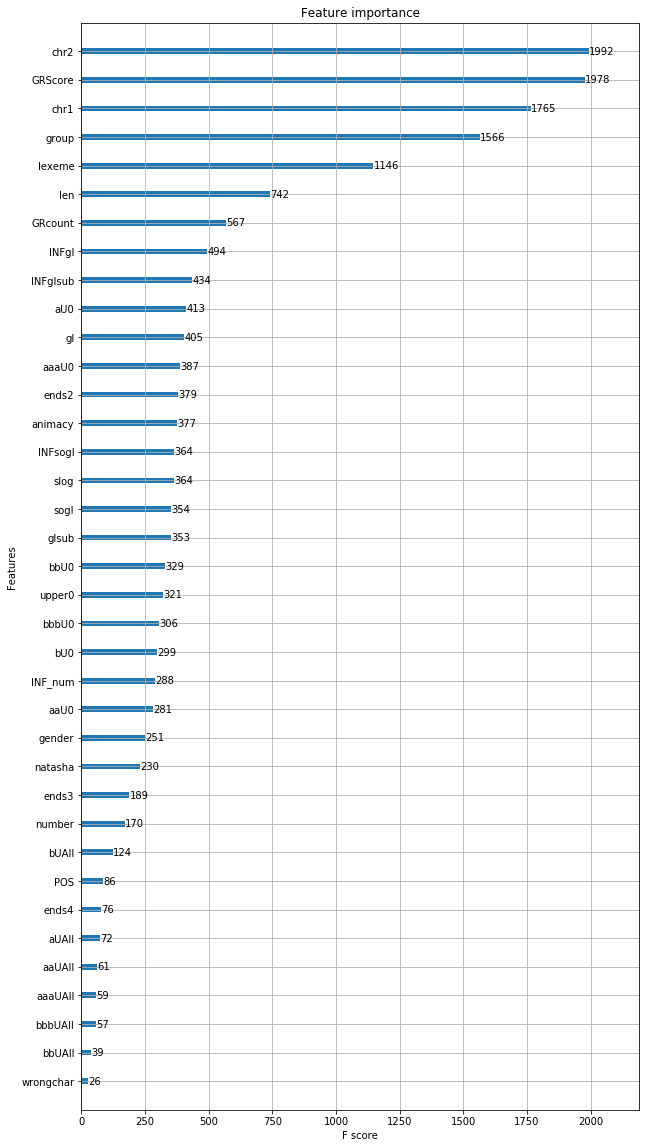

In [269]:
def my_plot_importance(booster, figsize, **kwargs): 
    from matplotlib import pyplot as plt
    from xgboost import plot_importance
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax, **kwargs)
%matplotlib inline
my_plot_importance(model1, (10,20))

gender      -0.024427
ends2        0.089751
chr1        -0.004793
chr2         0.022013
len2         0.000824
upperAl     -0.038522
wrongchar   -0.020437
num         -0.002483
glsub       -0.007631
INFsogl     -0.093453
INFglsub     0.010279
bUAll        0.020115
aUAll       -0.021943
bbUAll      -0.013153
aaUAll      -0.015823
bbbUAll     -0.014599
aaaUAll     -0.008480
Name: Label, dtype: float64

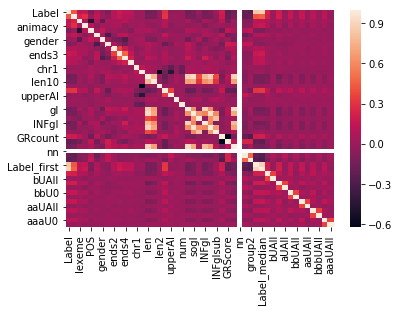

In [270]:
correl_corr = correl.corr()
sns.heatmap(correl_corr)
correl_corr['Label'].drop('Label')[(abs(correl_corr['Label'].drop('Label'))<0.1 )]

In [272]:
np.random.seed(17)
test_cop = prepare(voc,test)
test_cop.head()
del(test_cop['Word'])
del(test_cop['INF'])

d_test = xgb.DMatrix(test_cop)
predict = pd.Series(model1.predict(d_test))
ans = pd.DataFrame({'Prediction':predict })
ans.to_csv('answ.csv',index_label='Id',columns=['Prediction'])#,columns=['Label']